# Asteroid Route Optimization


In [1]:
from imp import reload
import sys
import os
import os.path
from glob import glob
import numpy as np
import pandas as pd
# print(sys.version)
pd.show_versions()
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.use14corefonts'] = True
#matplotlib.rcParams['text.usetex'] = False
# Use Type 1 fonts in plots.
matplotlib.rc('pdf', fonttype=42)
matplotlib.rcParams['font.size'] = 12
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner


INSTALLED VERSIONS
------------------
commit           : 945c9ed766a61c7d2c0a7cbb251b6edebf9cb7d5
python           : 3.8.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.8.0-41-generic
Version          : #46~20.04.1-Ubuntu SMP Mon Jan 18 17:52:23 UTC 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_GB.UTF-8
LOCALE           : en_GB.UTF-8

pandas           : 1.3.4
numpy            : 1.20.3
pytz             : 2019.3
dateutil         : 2.7.3
pip              : 20.0.2
setuptools       : 45.2.0
Cython           : 3.0a6
pytest           : 4.6.9
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.5.0
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.13.0
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
f

In [2]:
#dfbest = pd.read_csv('best_fitness_selected.csv',sep=';')
def get_opt(instpath):
    instance_name = instpath.split('/')[-1].replace('.dat','').replace('.txt','')
    sol = dfbest[dfbest.instance_name==instance_name]
    if len(sol) != 1: 
        print("No opt value")
        return np.nan
    if sol.best_known_subdiagonal.isna().bool():
        return sol.best_known.iloc[0]
    else:
        return sol.best_known_subdiagonal.iloc[0]

def read_alldata(pat="./results/**/*.csv.xz"):
    lis = []
    for filename in glob(pat, recursive=True):
        tmp = pd.read_csv(filename)
        print(filename)
        #tmp.instance = tmp.instance.str.replace('pfsp/','pfsp_cmax/')
        if "dist_hamming" in filename:
            tmp['Distance'] = "hamming"
        elif "dist_kendall" in filename:
            tmp['Distance'] = "kendall"
        if "umm2" in filename:
             tmp['Solver'] = "UMM2"
        if "-er0" in filename:
            tmp['Solver'] += "_order"
        elif "-er1" in filename:
            tmp['Solver'] += "_rank"
        tmp['Solver'] += '_'
        tmp['Solver'] += tmp.budget.astype(str)
        lis.append(tmp)
    df = pd.concat(lis, sort = True)
    # Fix instance names
    df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
    df['Instance'] = df['Instance'].str.replace('.txt','', regex=False).str.replace('.dat', '', regex=False)
    # Let's include the name just to be clear in the output.
    df['instance'] = 'ARP_' + df['instance']
    return df

def check_runs(df, nruns):
    df2 = df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].sum()
    totalruns = np.arange(1, nruns + 1).sum()
    assert (df2 == totalruns).all(),f"{df2[df2 != totalruns]}"
    assert (df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].nunique() == nruns).all()

# If runs were terminated after different number of evaluations, 
# use only the evaluations reached in all runs to avoid misleading mean and variance.
def filter_unequal_budget(df, budget):
    groups = ['Solver','instance','eval_ranks','Distance']
    df_max_evals = df[df.Solver.str.startswith("CEGO")].groupby(groups + ['seed'])['Function evaluations'].max()
    df_max_evals = df_max_evals.groupby(groups).min()
    for index,row  in df_max_evals.reset_index().iterrows():
        if row['Function evaluations'] == budget: continue
        before = df.shape[0]
        # FIXME: How to do this in a shorter manner?
        df = df[~((df.Solver == row.Solver) & (df.instance == row.instance) & (df.eval_ranks == row.eval_ranks) & (df.Distance == row.Distance) & (df['Function evaluations'] > row['Function evaluations']))]
        print(f"Removed {before - df.shape[0]} rows for Solver={row.Solver} instance={row.instance} eval_ranks={row.eval_ranks} Distance={row.Distance}")
    return df

df = read_alldata()
# This is only for synthetic LOPs
#df['Uniformity'] = df.instance.str.extract(r'phi=(.+)$').astype(float)
# These are the instances used in the paper
sel_insts = ['lop/IO/N-t59d11xx' ,'lop/IO/N-t59b11xx' ,'lop/SGB/N-sgb75.01' ,'lop/SGB/N-sgb75.02',
             'lop/RandB/N-p40-01','lop/RandB/N-p40-02' ,'lop/RandB/N-p50-02', 'lop/RandB/N-p50-01',
             'pfsp_cmax/rec05.txt','pfsp_cmax/rec13.txt', 'pfsp_cmax/rec19.txt',  'pfsp_cmax/rec31.txt']
sel_insts = None
if sel_insts:
    df = df[(mask) & (df.instance.isin(sel_insts))]
else:
    sel_insts = np.sort(df.instance.unique())
nruns = 5
df = filter_unequal_budget(df, 1000)
df = df.sort_values(['Problem', 'instance', 'Solver', 'eval_ranks', 'budget','seed','Function evaluations'])
df['Best-so-far fitness'] = df.groupby(['Problem', 'instance','Solver', 'eval_ranks', 'budget','seed'])['Fitness'].cummin()
# Checks that make sure we have the correct number of runs
check_runs(df, nruns)

./results/m200-er1/arp_15_42/umm-maxmindist.csv.xz
./results/m200-er1/arp_15_42/umm2-maxmindist.csv.xz
./results/m200-er1/arp_15_42/cego.csv.xz
./results/m200-er1/arp_20_42/umm-maxmindist.csv.xz
./results/m200-er1/arp_20_42/umm2-maxmindist.csv.xz
./results/m200-er1/arp_20_42/cego.csv.xz
./results/m200-er1/arp_10_42/umm-maxmindist.csv.xz
./results/m200-er1/arp_10_42/umm2-maxmindist.csv.xz
./results/m200-er1/arp_10_42/cego.csv.xz
./results/m100-er0/arp_15_42/umm-maxmindist.csv.xz
./results/m100-er0/arp_15_42/umm2-maxmindist.csv.xz
./results/m100-er0/arp_15_42/cego.csv.xz
./results/m100-er0/arp_20_42/umm-maxmindist.csv.xz
./results/m100-er0/arp_20_42/umm2-maxmindist.csv.xz
./results/m100-er0/arp_20_42/cego.csv.xz
./results/m100-er0/arp_10_42/umm-maxmindist.csv.xz
./results/m100-er0/arp_10_42/umm2-maxmindist.csv.xz
./results/m100-er0/arp_10_42/cego.csv.xz
./results/m1000-er0/arp_15_42/umm-maxmindist.csv.xz
./results/m1000-er0/arp_15_42/umm2-maxmindist.csv.xz
./results/m1000-er0/arp_20_42/u

In [3]:
df

,Distance,Fitness,Function evaluations,Problem,Solver,budget,budgetGA,eval_ranks,init,instance,...,phi_estim,phi_sample,ratio_samples_learn,rho,run_time,seed,weight_mass_learn,x,Instance,Best-so-far fitness
0,NaN,624.589952,1,ARP,CEGO_order_100,100,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,9869.039741,1,NaN,3 4 6 1 5 8 2 9 0 7,10_42,624.589952
1,NaN,602.299570,2,ARP,CEGO_order_100,100,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,9869.039741,1,NaN,7 3 4 8 1 5 6 0 9 2,10_42,602.299570
2,NaN,424.744236,3,ARP,CEGO_order_100,100,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,9869.039741,1,NaN,5 6 8 4 7 2 9 0 1 3,10_42,424.744236
3,NaN,526.209393,4,ARP,CEGO_order_100,100,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,9869.039741,1,NaN,4 3 1 2 5 0 9 8 7 6,10_42,424.744236
4,NaN,503.602029,5,ARP,CEGO_order_100,100,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,9869.039741,1,NaN,8 9 7 4 1 5 2 6 3 0,10_42,424.744236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,930.342077,496,ARP,UMM_rank_500,500,NaN,1,maxmindist,ARP_20_42,...,NaN,0.09375,0.1,6.705523e-08,2489.837511,5,0.9,18 0 3 7 4 9 6 19 1 11 2 13 16 15 10 5 8 12 14 17,20_42,867.769054
2496,NaN,1112.755786,497,ARP,UMM_rank_500,500,NaN,1,maxmindist,ARP_20_42,...,NaN,0.09375,0.1,5.960464e-08,2489.837511,5,0.9,18 0 4 6 3 8 7 19 2 11 1 14 16 15 10 5 9 12 13 17,20_42,867.769054
2497,NaN,1001.833843,498,ARP,UMM_rank_500,500,NaN,1,maxmindist,ARP_20_42,...,NaN,0.09375,0.1,5.960464e-08,2489.837511,5,0.9,19 0 4 7 3 8 6 18 2 11 1 14 16 15 10 5 9 12 13 17,20_42,867.769054
2498,NaN,1043.220002,499,ARP,UMM_rank_500,500,NaN,1,maxmindist,ARP_20_42,...,NaN,0.06250,0.1,5.960464e-08,2489.837511,5,0.9,18 0 4 7 2 8 6 19 3 11 1 14 16 15 10 5 9 12 13 17,20_42,867.769054


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', None,'display.max_colwidth', -1):
    print(df.groupby(["Solver","instance"])['seed'].unique())
    print(df.groupby(["Solver","instance"])['seed'].sum())

Solver           instance 
CEGO_order_100   ARP_10_42    [1, 2, 3, 4, 5]
                 ARP_15_42    [1, 2, 3, 4, 5]
                 ARP_20_42    [1, 2, 3, 4, 5]
CEGO_order_200   ARP_10_42    [1, 2, 3, 4, 5]
                 ARP_15_42    [1, 2, 3, 4, 5]
                 ARP_20_42    [1, 2, 3, 4, 5]
CEGO_rank_100    ARP_10_42    [1, 2, 3, 4, 5]
                 ARP_15_42    [1, 2, 3, 4, 5]
                 ARP_20_42    [1, 2, 3, 4, 5]
CEGO_rank_200    ARP_10_42    [1, 2, 3, 4, 5]
                 ARP_15_42    [1, 2, 3, 4, 5]
                 ARP_20_42    [1, 2, 3, 4, 5]
UMM2_order_100   ARP_10_42    [1, 2, 3, 4, 5]
                 ARP_15_42    [1, 2, 3, 4, 5]
                 ARP_20_42    [1, 2, 3, 4, 5]
UMM2_order_1000  ARP_10_42    [1, 2, 3, 4, 5]
                 ARP_15_42    [1, 2, 3, 4, 5]
UMM2_order_200   ARP_10_42    [1, 2, 3, 4, 5]
                 ARP_15_42    [1, 2, 3, 4, 5]
                 ARP_20_42    [1, 2, 3, 4, 5]
UMM2_order_500   ARP_10_42    [1, 2, 3, 4, 5]
       

## Plot results
Plot the fitness over evaluations for all instances in the paper.

instance:  ARP_10_42
                           Fitness   size
Solver          budget                   
CEGO_order_100  100     414.565158    500
CEGO_order_200  200     396.951854   1000
UMM2_order_100  100     424.797720   1000
UMM2_order_1000 1000    385.808219  10000
UMM2_order_200  200     395.645559   2000
UMM2_order_500  500     388.186651   5000
UMM_order_100   100     409.082713    500
UMM_order_1000  1000    378.682678   5000
UMM_order_200   200     389.962440   1000
UMM_order_500   500     378.798184   2500


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif


Saving to img/fitness_ARP_10_42.pdf


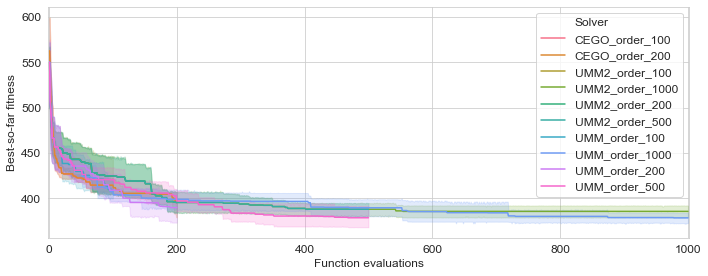

instance:  ARP_10_42
                         Fitness  size
Solver        budget                  
CEGO_rank_100 100     391.998562   500
CEGO_rank_200 200     371.876906  1000
UMM2_rank_100 100     427.734150  1000
UMM2_rank_200 200     419.722792  2000
UMM2_rank_500 500     396.789801  5000
UMM_rank_100  100     418.618541   500
UMM_rank_1000 1000    380.061090  5000
UMM_rank_200  200     412.556142  1000
UMM_rank_500  500     393.831633  2500
Saving to img/fitness_ARP_10_42.pdf


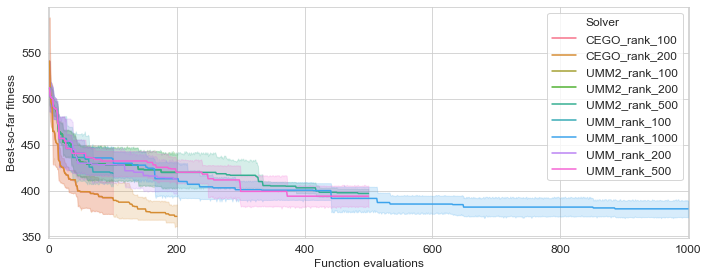

instance:  ARP_15_42
                           Fitness  size
Solver          budget                  
CEGO_order_100  100     634.921134   500
CEGO_order_200  200     616.378804  1000
UMM2_order_100  100     628.570319  1000
UMM2_order_1000 1000    580.572751  9000
UMM2_order_200  200     618.714129  2000
UMM2_order_500  500     592.981980  5000
UMM_order_100   100     631.261067   500
UMM_order_1000  1000    576.066340  5000
UMM_order_200   200     619.496389  1000
UMM_order_500   500     593.144130  2500
Saving to img/fitness_ARP_15_42.pdf


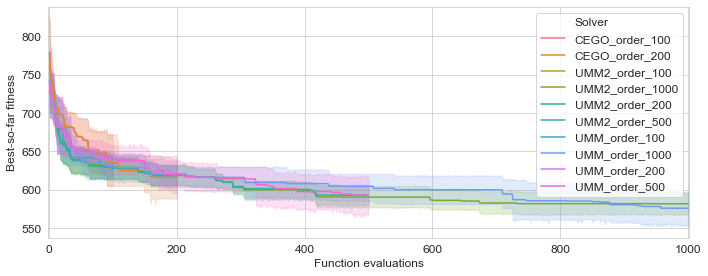

instance:  ARP_15_42
                         Fitness  size
Solver        budget                  
CEGO_rank_100 100     639.735428   500
CEGO_rank_200 200     611.962470  1000
UMM2_rank_100 100     628.881376  1000
UMM2_rank_200 200     621.054742  2000
UMM2_rank_500 500     606.206453  5000
UMM_rank_100  100     635.580912   500
UMM_rank_1000 1000    599.165262  5000
UMM_rank_200  200     634.748443  1000
UMM_rank_500  500     618.371453  2500
Saving to img/fitness_ARP_15_42.pdf


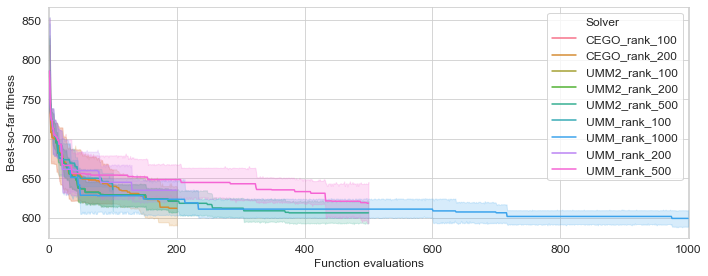

instance:  ARP_20_42
                          Fitness  size
Solver         budget                  
CEGO_order_100 100     875.511873   500
CEGO_order_200 200     853.952806  1000
UMM2_order_100 100     863.105866  1000
UMM2_order_200 200     848.435120  2000
UMM2_order_500 500     834.944017  5000
UMM_order_100  100     858.670581   500
UMM_order_1000 1000    826.039332  5000
UMM_order_200  200     857.500056  1000
UMM_order_500  500     821.149488  2500
Saving to img/fitness_ARP_20_42.pdf


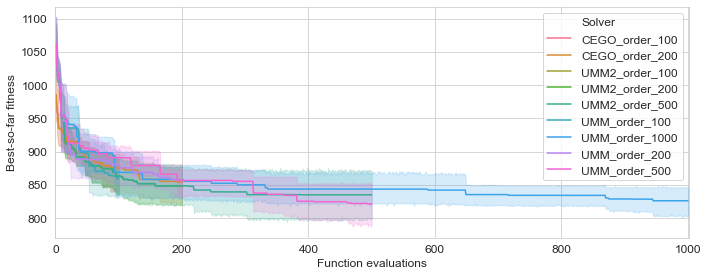

instance:  ARP_20_42
                         Fitness  size
Solver        budget                  
CEGO_rank_100 100     872.622610   500
CEGO_rank_200 200     834.071417  1000
UMM2_rank_100 100     852.375425  1000
UMM2_rank_200 200     847.177209  2000
UMM2_rank_500 500     841.599179  5000
UMM_rank_100  100     882.702724   500
UMM_rank_1000 1000    852.340195  5000
UMM_rank_200  200     871.063301  1000
UMM_rank_500  500     850.702255  2500
Saving to img/fitness_ARP_20_42.pdf


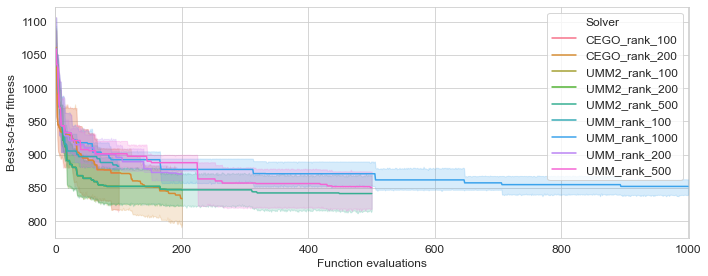

In [5]:
def plot_fitness(df, inst, best = False):
    print("instance: ", inst)
    if len(df) == 0: return
    df_fitness = df.groupby(['Solver','budget','seed']).Fitness.min().reset_index()
    df_fitness = df_fitness.pivot_table(index=['Solver','budget'], values='Fitness')
    df_fitness['size'] = df.groupby(['Solver', 'budget'])['Fitness'].size()
    print(df_fitness)
    budget = df.budget.max()
    plt.figure(figsize=(10,4))
    val_opt = None #get_opt(inst)
    if val_opt is not None: 
        print("optimum: ", val_opt)
        plt.plot([0,budget],[val_opt,val_opt])
    palette = sns.color_palette("husl", subdf['Solver'].nunique())
    if best:
        y_col = 'Best-so-far fitness' 
    else:
        y_col = 'Fitness'
    g = sns.lineplot(x='Function evaluations', y=y_col, hue='Solver', data=df, palette=palette)
    g.set(xlim=(-1, budget+1))
    plt.tight_layout()
    filename = 'img/fitness_' + df.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()  

sel_inst = df.instance.unique()
for inst in sel_inst:
    for _, gdf in df.groupby('eval_ranks'):
        subdf = gdf[gdf.instance.str.contains(inst)].sort_values('Solver')
        plot_fitness(subdf, inst, best = True)
        

## Summary table of the results

Table with the summary of the results

In [6]:
sel_confs = list(df.Solver.unique()) #['CEGO_rank_200', 'UMM_order_200']
# The maximum time per seed and evaluation is the final time. 
dftime = df.groupby(['Solver','Problem','Instance','seed']).run_time.max().reset_index()
dftime
# Then we calculate the mean per instance.
dftime['run_time'] =  (dftime['run_time'] / 60.0).round(1)
dftime = dftime.pivot_table(index=['Problem','Instance'], columns='Solver',values='run_time').reset_index()
dftime.columns.name  = ''
dftime
dftime = dftime[['Problem', 'Instance'] + sel_confs]
dftime#.sort_values(by='Instance')

print(dftime.to_latex(index=False))

\begin{tabular}{llrrrrrrrrrrrrrrrrrrr}
\toprule
Problem & Instance &  CEGO\_order\_100 &  CEGO\_order\_200 &  CEGO\_rank\_100 &  CEGO\_rank\_200 &  UMM2\_order\_100 &  UMM2\_order\_1000 &  UMM2\_order\_200 &  UMM2\_order\_500 &  UMM2\_rank\_100 &  UMM2\_rank\_200 &  UMM2\_rank\_500 &  UMM\_order\_100 &  UMM\_order\_1000 &  UMM\_order\_200 &  UMM\_order\_500 &  UMM\_rank\_100 &  UMM\_rank\_1000 &  UMM\_rank\_200 &  UMM\_rank\_500 \\
\midrule
    ARP &    10\_42 &          163.82 &          351.64 &         221.00 &         405.10 &           11.86 &           159.28 &           25.48 &           59.04 &          17.80 &          26.10 &          80.58 &           4.34 &           57.80 &          11.70 &          30.08 &          6.98 &          62.62 &         12.32 &         29.08 \\
    ARP &    15\_42 &          150.50 &          364.86 &         172.54 &         483.86 &           16.38 &           165.82 &           32.12 &           81.30 &          15.76 &          27.18 &      

In [7]:
df_fitness = df.groupby(['Solver', 'Problem','Instance','seed']).Fitness.min().reset_index()
# df_fitness = df_fitness.groupby(['Solver','Problem','instance']).Fitness.agg(MeanFitness='mean').reset_index()
df_fitness = df_fitness.pivot_table(index=['Problem', 'Instance'], columns='Solver', values=['Fitness']).reset_index()

df_fitness.columns = [b if b != '' else a for (a,b)  in df_fitness.columns]
df_fitness = df_fitness[['Problem', 'Instance'] + sel_confs]
df_fitness
print(df_fitness.to_latex(index=False))

\begin{tabular}{llrrrrrrrrrrrrrrrrrrr}
\toprule
Problem & Instance &  CEGO\_order\_100 &  CEGO\_order\_200 &  CEGO\_rank\_100 &  CEGO\_rank\_200 &  UMM2\_order\_100 &  UMM2\_order\_1000 &  UMM2\_order\_200 &  UMM2\_order\_500 &  UMM2\_rank\_100 &  UMM2\_rank\_200 &  UMM2\_rank\_500 &  UMM\_order\_100 &  UMM\_order\_1000 &  UMM\_order\_200 &  UMM\_order\_500 &  UMM\_rank\_100 &  UMM\_rank\_1000 &  UMM\_rank\_200 &  UMM\_rank\_500 \\
\midrule
    ARP &    10\_42 &      414.565158 &      396.951854 &     391.998562 &     371.876906 &      424.797720 &       385.808219 &      395.645559 &      388.186651 &     427.734150 &     419.722792 &     396.789801 &     409.082713 &      378.682678 &     389.962440 &     378.798184 &    418.618541 &     380.061090 &    412.556142 &    393.831633 \\
    ARP &    15\_42 &      634.921134 &      616.378804 &     639.735428 &     611.962470 &      628.570319 &       580.572751 &      618.714129 &      592.981980 &     628.881376 &     621.054742 &     6

In [8]:
# Keep only one CEGO and one UMM
df = df[df.Solver.isin(['CEGO_inv','UMM_400'])]
# Make sure we have the right data
mask = ((df.budget==400) & (df.eval_ranks==0)&((df.budgetMM == 1) | (df.budgetMM.isna())))
df = df[mask]
df.Solver = df.Solver.str.replace('CEGO_inv','CEGO').str.replace('UMM_400', 'UMM')

# The maximum time per seed and evaluation is the final time.
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max()
# Then we calculate the mean per instance.
dftime = dftime.groupby(['Solver','Problem','instance']).mean().reset_index()
# Convert to hours
dftime['run_time'] =  (dftime['run_time'] / 3600.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time')
dftime.rename(columns={'CEGO':'CEGO Runtime', 'UMM':'UMM Runtime'}, inplace=True)

# FEvals of CEGO
tmp = df[df.Solver == 'CEGO'].groupby(['Problem','instance','seed'])['Function evaluations'].max()
dftime['CEGO F. evaluations'] = tmp.groupby(['Problem','instance']).mean()

# Fitness
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
tmp_cego = df_fitness[df_fitness.Solver == 'CEGO'].groupby(['Problem','instance']).Fitness.agg(CEGO_Fitness_mean='mean', CEGO_Fitness_std='std').reset_index()
tmp_umm = df_fitness[df_fitness.Solver == 'UMM'].groupby(['Problem','instance']).Fitness.agg(UMM_Fitness_mean='mean', UMM_Fitness_std='std').reset_index()
df = pd.merge(tmp_cego, tmp_umm)
df.CEGO_Fitness_mean = df.CEGO_Fitness_mean.round(1)
df.CEGO_Fitness_std = "(" + df.CEGO_Fitness_std.round(1).astype(str) + ")"
df.UMM_Fitness_mean = df.UMM_Fitness_mean.round(1)
df.UMM_Fitness_std = "(" + df.UMM_Fitness_std.round(1).astype(str) + ")"
df = pd.merge(df, dftime, on=['Problem', 'instance'])

df = df.sort_values(['Problem', 'UMM Runtime', 'CEGO Runtime'])

for inst in df.instance:
    x, y = [ f.to_numpy() for _, f in df_fitness[df_fitness.instance == inst].groupby('Solver').Fitness]
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')])).replace('(','[').replace(')', ']')
    #df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))

# Keep only some columns
df = df[['Problem', 'Instance','CEGO_Fitness_mean','CEGO_Fitness_std','UMM_Fitness_mean','UMM_Fitness_std','Confidence interval','CEGO Runtime','UMM Runtime']]
df.reset_index(drop=True)#.to_csv('info.csv')

AttributeError: 'DataFrame' object has no attribute 'budgetMM'

In [ ]:
print(df.to_latex(index=False))